# Task 1

Here we will see how our nn and autograd works.

Also we will review some Catalyst's abstractions, implement callbacks and datasets.

Unfortunately, python is slow, and implementing dynamic computational graph in pure python for product-ready solution is not a good idea. But this task will help you to understand what's happening when you call `backward` method for variable or tensor. Also it will help you in learning Catalyst framework and will teach how you to write your code in more Catalyst-like way.

In [1]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from homework.micrograd.nn import Linear, ReLU, CrossEntropyLoss, Module
from homework.micrograd.optim import SGD
from homework.micrograd.engine import Value
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Defining toy dataset

To be more human-readable and easy to understand, we want to store every data in key-value format.

So, the dataset should yield dict, moreover we will store train/valid datasets in a dict.

In [2]:
class Dataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, item):
        return {"features": self.X[item], "targets": self.y[item]}

    def __len__(self):
        return len(self.y)



X, y = make_moons(200, noise=0.2)
X_train, X_val, y_train, y_val = train_test_split(X, y)
datasets = {"train": Dataset(X_train, y_train), "valid": Dataset(X_val, y_val)}

Take a look on a data.

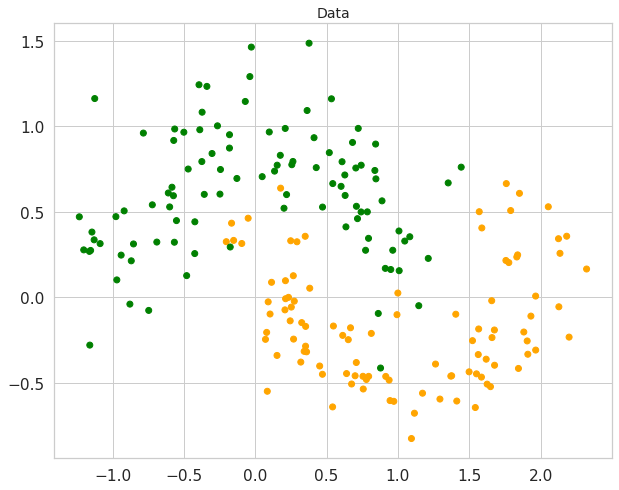

In [3]:
plt.figure(figsize=(10, 8))
plt.title("Data", fontsize=14)
colors = list(map(lambda x: "green" if x ==0 else "orange", y))
plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.show()

### Model

Let's define our model in PyTorch-style. But don't forget to implement `parameters()` method.

In [4]:
class SimpleModel(Module):
    def __init__(self):
        self.fc1 = Linear(2, 20)
        self.fc2 = Linear(20, 2)

    def forward(self, inp):
        x = self.fc1(inp)
        return self.fc2(ReLU()(x))

    def parameters(self):
        return self.fc1.parameters() + self.fc2.parameters()

## For loop

Let's start with simple train/test loop.

In [6]:
criterion = CrossEntropyLoss()
model = SimpleModel()
optimizer = SGD(model.parameters(), lr=0.01)

num_epochs = 200
batch_size = 32
log_period = 5

for epoch in range(num_epochs):
    current_batch = []
    metrics = {}
    for k, dataset in datasets.items():
        loader_metrics = {}
        epoch_loss = 0
        epoch_accuracy = 0
        for idx, data in enumerate(dataset):
            optimizer.zero_grad()
            last = idx == (len(dataset)-1)
            current_batch.append(data)
            if last or len(current_batch) == batch_size:
                loss = 0
                for data in current_batch:
                    res = model(data['features'])
                    current_loss = criterion(res, data['targets'])
                    epoch_loss += current_loss.data
                    loss += current_loss
                    if res.argmax() == data['targets']:
                        epoch_accuracy += 1
                loss = loss / len(current_batch)
                loss.backward()
                if k == "train":
                    optimizer.step()
                current_batch=[]
        if k == "valid":
            epoch_loss = epoch_loss/len(dataset)
            epoch_accuracy = epoch_accuracy/len(dataset)
            if epoch % log_period == 0:
                print(f"### EPOCH {epoch} ###")
                print(f"epoch_loss {epoch_loss}")
                print(f"epoch_accuracy {epoch_accuracy}")

### EPOCH 0 ###
epoch_loss 0.5107807693405583
epoch_accuracy 0.8
### EPOCH 5 ###
epoch_loss 0.41592129975230513
epoch_accuracy 0.86
### EPOCH 10 ###
epoch_loss 0.39673054663041796
epoch_accuracy 0.84
### EPOCH 15 ###
epoch_loss 0.3881832850391244
epoch_accuracy 0.84
### EPOCH 20 ###
epoch_loss 0.38347411685327787
epoch_accuracy 0.84
### EPOCH 25 ###
epoch_loss 0.38057041090204285
epoch_accuracy 0.84
### EPOCH 30 ###
epoch_loss 0.37862978284390253
epoch_accuracy 0.84
### EPOCH 35 ###
epoch_loss 0.3770815023579376
epoch_accuracy 0.84
### EPOCH 40 ###
epoch_loss 0.37551280745693644
epoch_accuracy 0.84
### EPOCH 45 ###
epoch_loss 0.3738653821433659
epoch_accuracy 0.84
### EPOCH 50 ###
epoch_loss 0.3724906323781525
epoch_accuracy 0.84
### EPOCH 55 ###
epoch_loss 0.37151309997338783
epoch_accuracy 0.84
### EPOCH 60 ###
epoch_loss 0.3700739787292971
epoch_accuracy 0.84
### EPOCH 65 ###
epoch_loss 0.3688487833989895
epoch_accuracy 0.84
### EPOCH 70 ###
epoch_loss 0.3674511843833566
epoch_accur


## General training loop - Catalyst intro - Runner¶

Code above can be reused for almost all machine learning task. Let's take a look on experiment structure

```
for stage in stage:
    for epoch in epochs:
        for loader on loaders:
            for batch in loader:
                # do something
```

### Runner

In most cases we only need to adapt our batch handling method. And here comes the Runner.

Runner is the main part of your experiment. It runs train loop, calls callbacks (we will discusds them later) and keeps track on your model. And the only thing you need to change is _handle_batch method.


In [7]:
from tqdm.notebook import tqdm


class Runner:
    def __init__(
        self,
        model,
        criterion,
        optimizer,
        datasets,
        batch_size
    ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.datasets = datasets

        self.batch_size = batch_size

        self.input = {}
        self.output = {}
        self.batch_metrics = {}
        self.loader_metrcis = {}
        self.epoch_metrics = {}

    def _handle_batch(self, batch, train=True):
        """
        Stores the main logic of data aggregating.
        """
        loss = 0
        correct = 0
        self.optimizer.zero_grad()
        for data in batch:
            # Calculate predictions, loss and metric
            res = self.model(data['features'])
            if res.argmax() == data['targets']:
                correct += 1
            current_loss = self.criterion(res, data['targets'])
            loss += current_loss
        
        loss = loss / len(batch)
        accuracy = correct / len(batch)
        
        if train:
            # Optimize model's parameters
            loss.backward()
            self.optimizer.step()

        self.batch_metrics = {"loss": loss.data, "accuracy": accuracy}


    def train(self, num_epochs: int = 100, verbose=False):
        for epoch in range(num_epochs):
            self.epoch_metrics = {}
            self.epoch = epoch
            for dataset_name, dataset in self.datasets.items():
                self.dataset_name = dataset_name
                self.loader_metrics = {}
                current_batch = []

                if verbose:
                    iter_ = tqdm(enumerate(dataset), total=len(dataset))
                else:
                    iter_ = enumerate(dataset)

                for idx, data in iter_:
                    last = idx == (len(dataset)-1)
                    current_batch.append(data)

                    if last or len(current_batch) == self.batch_size:
                        # Handle batch
                        if self.dataset_name == 'train':
                            self._handle_batch(current_batch)
                        else:
                            self._handle_batch(current_batch, train=False)
                        current_batch = []

                        for k, v in self.batch_metrics.items():
                            if k not in self.loader_metrics:
                                self.loader_metrics[k] = []
                            self.loader_metrics[k].append(v)
                
                for metric, value in self.loader_metrics.items():
                    value = np.mean(self.loader_metrics[metric])
                    self.loader_metrics[metric] = value
                    print(f"epoch {epoch}: {dataset_name} {metric} - {value}")

### Run training

In [8]:
criterion = CrossEntropyLoss()
model = SimpleModel()
optimizer = SGD(model.parameters(), lr=0.01)
runner = Runner(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    datasets=datasets,
    batch_size=32,
)
runner.train(100)

epoch 0: train loss - 0.5357531594037253
epoch 0: train accuracy - 0.8232954545454545
epoch 0: valid loss - 0.49978367866296536
epoch 0: valid accuracy - 0.8107638888888888
epoch 1: train loss - 0.46091158633110474
epoch 1: train accuracy - 0.8823863636363637
epoch 1: valid loss - 0.4688924856793121
epoch 1: valid accuracy - 0.8541666666666667
epoch 2: train loss - 0.42757179294668235
epoch 2: train accuracy - 0.8886363636363637
epoch 2: valid loss - 0.4513579015721607
epoch 2: valid accuracy - 0.8541666666666667
epoch 3: train loss - 0.4069151668913963
epoch 3: train accuracy - 0.8886363636363637
epoch 3: valid loss - 0.44017300117308816
epoch 3: valid accuracy - 0.8541666666666667
epoch 4: train loss - 0.39288780575547233
epoch 4: train accuracy - 0.8886363636363637
epoch 4: valid loss - 0.43250055046559077
epoch 4: valid accuracy - 0.8263888888888888
epoch 5: train loss - 0.3827610170319241
epoch 5: train accuracy - 0.8948863636363636
epoch 5: valid loss - 0.42698189718175195
epoch 

epoch 47: train loss - 0.3279715141134628
epoch 47: train accuracy - 0.8823863636363637
epoch 47: valid loss - 0.38922566531376146
epoch 47: valid accuracy - 0.8263888888888888
epoch 48: train loss - 0.3274084522841062
epoch 48: train accuracy - 0.8823863636363637
epoch 48: valid loss - 0.38931718778921176
epoch 48: valid accuracy - 0.8263888888888888
epoch 49: train loss - 0.32744233827972197
epoch 49: train accuracy - 0.8823863636363637
epoch 49: valid loss - 0.3892750362402787
epoch 49: valid accuracy - 0.8263888888888888
epoch 50: train loss - 0.3269580178313039
epoch 50: train accuracy - 0.8823863636363637
epoch 50: valid loss - 0.38788392869977245
epoch 50: valid accuracy - 0.8263888888888888
epoch 51: train loss - 0.3263759929933824
epoch 51: train accuracy - 0.8823863636363637
epoch 51: valid loss - 0.38792122251310546
epoch 51: valid accuracy - 0.8263888888888888
epoch 52: train loss - 0.326377783438171
epoch 52: train accuracy - 0.8823863636363637
epoch 52: valid loss - 0.387

epoch 94: train loss - 0.30678841579731275
epoch 94: train accuracy - 0.8886363636363637
epoch 94: valid loss - 0.36532317573103423
epoch 94: valid accuracy - 0.8263888888888888
epoch 95: train loss - 0.3061819399066174
epoch 95: train accuracy - 0.8886363636363637
epoch 95: valid loss - 0.3638111803050574
epoch 95: valid accuracy - 0.8263888888888888
epoch 96: train loss - 0.30539773266794523
epoch 96: train accuracy - 0.8886363636363637
epoch 96: valid loss - 0.3639323180705668
epoch 96: valid accuracy - 0.8263888888888888
epoch 97: train loss - 0.30488031208110467
epoch 97: train accuracy - 0.8886363636363637
epoch 97: valid loss - 0.3623052062937395
epoch 97: valid accuracy - 0.8263888888888888
epoch 98: train loss - 0.30407443043309995
epoch 98: train accuracy - 0.8948863636363636
epoch 98: valid loss - 0.36248237954879436
epoch 98: valid accuracy - 0.8263888888888888
epoch 99: train loss - 0.3036874644361479
epoch 99: train accuracy - 0.9011363636363636
epoch 99: valid loss - 0.3

### Visualization

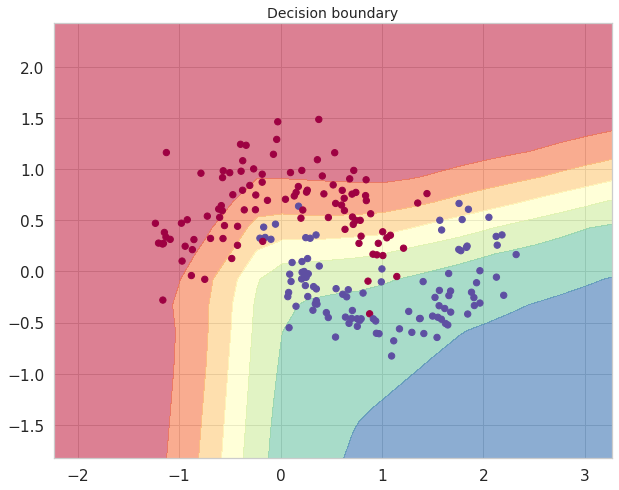

In [9]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s[1].exp().data/(s[0].exp()+s[1].exp()).data for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure(figsize=(10, 8))
plt.title("Decision boundary", fontsize=14)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()


## General training loop - Catalyst intro - Callbacks

But could we make it even more general? Should we rewrite loss.backward or compute accuracy again and again? Do we really need it?

I don't think so, I think, we could introduce another general abstaction for typical train-loop logic. Let's introduce Callbacks!

### Callbacks

In catalyst callbacks have significant impact in everything you do.
Let's try to implement some of them.

There are a list of moments, where callbacks can be integrated. We will need only three of them.
```
on_stage_start
    on_epoch_start
        on_loader_start
            on_batch_start
------->    on_batch_end
----->  on_loader_end
--> on_epoch_end
on_stage_end
```

In [10]:
class Callback:
    def on_stage_start(self):
        pass

    def on_stage_end(self):
        pass

    def on_epoch_start(self):
        pass

    def on_epoch_end(self, runner):
        pass

    def on_loader_start(self):
        pass

    def on_loader_end(self, runner):
        pass

    def on_batch_start(self, runner):
        pass

    def on_batch_end(self, runner):
        pass


class LossCallback(Callback):
    """
    Aggregating loss value.
    """
    def __init__(self):
        self.cum_loss = 0
        self.num_batches = 0

    def on_batch_end(self, runner):
        """
        On batch end action.

        Accumulates loss and num batches.

        Args:
            output: dict with loss and other model's outputs.
        """
        self.cum_loss += runner.batch_loss.data
        self.num_batches += 1

    def on_loader_end(self, runner):
        """
        On loader end action.

        Args:
            epoch_metrics: dict with epoch metrics

        Returns:
            loss over the loader.
        """
        runner.epoch_metrics["loss"] = self.cum_loss / self.num_batches
        self.cum_loss = 0
        self.num_batches = 0


class AccuracyCallback(Callback):
    """
    Aggregating accuracy value.
    """
    def __init__(self):
        self.correct = 0

    def on_batch_end(self, runner):
        """
        On batch end action

        Accumulates number of correct predictions.

        Args:
            output: dict with number of the correct predictions
        """
        for data, outp in zip(runner.input, runner.output):
            if outp.argmax() == data['targets']:
                self.correct += 1

    def on_loader_end(self, runner):
        """
        On loader end action.

        Args:
            epoch_metrics: dict with epoch metrics

        Returns:
            accuracy value over the loader.
        """
        len_ = len(runner.datasets[runner.dataset_name])
        runner.epoch_metrics["accuracy"] = self.correct/len_
        self.correct=0


class LoggerCallback(Callback):
    """
    Log metrics to output.
    """
    def __init__(self, log_period):
        self.log_period = log_period

    def on_epoch_end(self, runner):
        """
        On epoch end action.

        Prints all epoch metrics if log_period is suitable.

        Args:
            epoch_metrics: dict with epoch metrics
            epoch: current epoch
        """
        if (runner.epoch+1) % self.log_period == 0:
            log_string = f"Epoch: {runner.epoch}\n"
            for metric, value in runner.epoch_metrics.items():
                log_string += f"{metric}: {value}\n"
            print(log_string)


class OptimizerCallback(Callback):
    def on_batch_start(self, runner):
        if runner.dataset_name == "train":
            # Reset gradients
            runner.optimizer.zero_grad()

    def on_batch_end(self, runner):
        if runner.dataset_name == "train":
            runner.batch_loss.backward()
            runner.optimizer.step()

In [11]:
from tqdm.notebook import tqdm


class Runner:
    def __init__(
        self,
        model,
        criterion,
        optimizer,
        datasets,
        batch_size,
        callbacks,
    ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.datasets = datasets

        self.batch_size = batch_size
        self.callbacks = callbacks
        
        self.input = {}
        self.output = {}
        self.batch_loss = 0
        self.batch_metrics = {}
        self.loader_metrcis = {}
        self.epoch_metrics = {}

    def _handle_batch(self, batch):
        """
        Stores the main logic of data aggregating.
        """
        loss = 0
        output = []
        for data in batch:
            # Calculate predictions
            res = self.model(data['features'])
            output.append(res)
            current_loss = self.criterion(res, data['targets'])
            loss += current_loss
        
        loss = loss / len(batch)
        self.batch_loss = loss
        self.input = batch
        self.output = output


    def train(self, num_epochs: int = 100, verbose=False):
        for epoch in range(num_epochs):
            self.epoch_metrics = {}
            self.epoch = epoch
            for dataset_name, dataset in self.datasets.items():
                self.dataset_name = dataset_name
                self.loader_metrics = {}
                current_batch = []

                if verbose:
                    iter_ = tqdm(enumerate(dataset), total=len(dataset))
                else:
                    iter_ = enumerate(dataset)

                for idx, data in iter_:
                    last = idx == (len(dataset)-1)
                    current_batch.append(data)

                    if last or len(current_batch) == self.batch_size:
                        for clb in self.callbacks.values():
                            clb.on_batch_start(self)

                        # Handle batch
                        self._handle_batch(current_batch)
                        current_batch = []

                        for clb in self.callbacks.values():
                            clb.on_batch_end(self)

                for clb in self.callbacks.values():
                    clb.on_loader_end(self)
            for clb in self.callbacks.values():
                clb.on_epoch_end(self)

### Run training

In [12]:
criterion = CrossEntropyLoss()
model = SimpleModel()
optimizer = SGD(model.parameters(), lr=0.05)
runner = Runner(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    datasets=datasets,
    batch_size=4,
    callbacks={
        "loss": LossCallback(),
        "accuracy": AccuracyCallback(),
        "logger": LoggerCallback(log_period=5),
        "optimizer": OptimizerCallback(),
    }
)
runner.train(100)

Epoch: 4
loss: 0.3799523337422007
accuracy: 0.84

Epoch: 9
loss: 0.35752659068170006
accuracy: 0.84

Epoch: 14
loss: 0.32807174066646483
accuracy: 0.88

Epoch: 19
loss: 0.28227392949487673
accuracy: 0.94

Epoch: 24
loss: 0.2508644506535796
accuracy: 0.94

Epoch: 29
loss: 0.22447628593962515
accuracy: 0.94

Epoch: 34
loss: 0.19555317970938096
accuracy: 0.94

Epoch: 39
loss: 0.18723536225142962
accuracy: 0.92

Epoch: 44
loss: 0.18650054756694828
accuracy: 0.92

Epoch: 49
loss: 0.17858638151267997
accuracy: 0.92

Epoch: 54
loss: 0.15880005198835784
accuracy: 0.94

Epoch: 59
loss: 0.1636355205835397
accuracy: 0.92

Epoch: 64
loss: 0.15675633973084052
accuracy: 0.96

Epoch: 69
loss: 0.1588213321456548
accuracy: 0.94

Epoch: 74
loss: 0.15865338332162487
accuracy: 0.94

Epoch: 79
loss: 0.16444974107362686
accuracy: 0.92

Epoch: 84
loss: 0.16284777201369405
accuracy: 0.92

Epoch: 89
loss: 0.16800596710390703
accuracy: 0.94

Epoch: 94
loss: 0.16784766864789263
accuracy: 0.92

Epoch: 99
loss: 0.

### Visualization

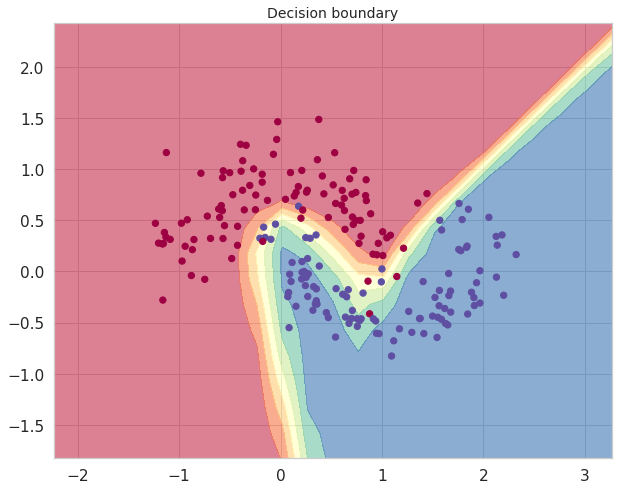

In [13]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s[1].exp().data/(s[0].exp()+s[1].exp()).data for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure(figsize=(10, 8))
plt.title("Decision boundary", fontsize=14)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()


## MNIST

Try to train model on MNIST task!

In [14]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [15]:
class MNISTDataset:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        return {"features": self.x[idx], "targets": self.y[idx]}

    def __len__(self):
        return len(self.y)

# Python is slow, that's why we use only small group of object
datasets = {
    "train": MNISTDataset(X_train[:500], y_train[:500]),
    "valid": MNISTDataset(X_val[:200], y_val[:200])
} 

In [16]:
class MnistModel(Module):
    def __init__(
        self,
        inp_shape=28*28,
        out_shape=10,
        hidden_shapes=[10, 10]
    ):
        self.fc1 = Linear(inp_shape, hidden_shapes[0])
        self.fc2 = Linear(hidden_shapes[1], out_shape)

    def forward(self, inp):
        inp = inp.reshape(28*28)
        x = self.fc1(inp)
        return self.fc2(ReLU()(x))

    def parameters(self):
        return self.fc1.parameters() + self.fc2.parameters()

In [17]:
criterion = CrossEntropyLoss()
model = MnistModel()
optimizer = SGD(model.parameters(), lr=0.1)
runner = Runner(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    datasets=datasets,
    batch_size=3,
    callbacks={
        "loss": LossCallback(),
        "accuracy": AccuracyCallback(),
        "logger": LoggerCallback(log_period=1),
        "optimizer": OptimizerCallback(),
    }
)
runner.train(5, verbose=True)


Epoch: 0
loss: 2.32210168801921
accuracy: 0.1



SystemError: <built-in function isinstance> returned a result with an error set